In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [18]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016
nielsen = pd.concat((nielsen15, nielsen16))
nielsen = nielsen[~nielsen.is_walmart]
density_path = r"C:\Users\inesn\Documents\Mines\2A\TR\econometrics\data_collection\plein_de_data\Average_Household_Size_and_Population_Density_-_County.csv"
density = pd.read_csv(density_path)
density = density[["GEOID", "B01001_calc_PopDensity"]]
nielsen = pd.merge(nielsen, density,  how='inner', left_on='guessed_store_county_fips', right_on='GEOID')

## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes still remain)
fandom = fandom[~np.isin(fandom.State, ['CA', 'GA', 'KS', 'LA', 'TX'])]
nielsen = nielsen[~np.isin(nielsen.store_state, ['CA', 'GA', 'KS', 'LA', 'TX'])]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
movements['year'] = movements.Opening_date.dt.year
movements['month'] = movements.Opening_date.dt.month

nielsen.groupby('product_group_descr').count().sort_values('upc_price', ascending=False).head(20)

C:\Users\inesn\AppData\Local\Temp\ipykernel_23564\716545586.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movements['year'] = movements.Opening_date.dt.year
C:\Users\inesn\AppData\Local\Temp\ipykernel_23564\716545586.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movements['month'] = movements.Opening_date.dt.month


,is_walmart,store_state,guessed_store_county,guessed_store_county_fips,purchase_year,purchase_month,upc_price,upc_price_std,nb_of_obs,year,GEOID,B01001_calc_PopDensity
product_group_descr,,,,,,,,,,,,
FRESH PRODUCE,42329,42329,42329,42329,42329,42329,42329,40500,42329,42329,42329,42329
BREAD AND BAKED GOODS,41725,41725,41725,41725,41725,41725,41725,38980,41725,41725,41725,41725
MILK,40079,40079,40079,40079,40079,40079,40079,36097,40079,40079,40079,40079
SNACKS,39978,39978,39978,39978,39978,39978,39978,36697,39978,39978,39978,39978
PACKAGED MEATS-DELI,39929,39929,39929,39929,39929,39929,39929,36608,39929,39929,39929,39929
CHEESE,39595,39595,39595,39595,39595,39595,39595,36234,39595,39595,39595,39595
UNPREP MEAT/POULTRY/SEAFOOD-FRZN,39240,39240,39240,39240,39240,39240,39240,36505,39240,39240,39240,39240
CARBONATED BEVERAGES,37764,37764,37764,37764,37764,37764,37764,33777,37764,37764,37764,37764
"CONDIMENTS, GRAVIES, AND SAUCES",37701,37701,37701,37701,37701,37701,37701,33389,37701,37701,37701,37701


## FRESH PRODUCE

## THIRD MODEL : adding entity effects

In [40]:
# Find the best states
category = "PASTA"
product_group = nielsen[nielsen.product_group_descr == category]
treatment = product_group.copy()
control = product_group.copy()
print(control.shape[0])
# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]
treatment = treatment[np.isin(treatment.guessed_store_county_fips, treatment_movements.County_fips )].copy()
control = control[~np.isin(control.guessed_store_county_fips, treatment_movements.County_fips )].copy()
print(control.shape[0])
#treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
#print(treatment.shape[0])
treatment.groupby('store_state').nunique().head(60)

29612
27726


,is_walmart,guessed_store_county,guessed_store_county_fips,purchase_year,purchase_month,product_group_descr,upc_price,upc_price_std,nb_of_obs,year,GEOID,B01001_calc_PopDensity
store_state,,,,,,,,,,,,
AL,1,3,3,2,12,1,62,54,18,2,3,3
AR,1,3,3,2,12,1,38,26,6,2,3,3
AZ,1,4,4,2,12,1,85,85,55,2,4,4
CO,1,4,4,2,12,1,76,74,43,2,4,4
DC,1,1,1,2,12,1,24,24,16,2,1,1
FL,1,9,9,2,12,1,214,216,84,2,9,9
ID,1,1,1,2,12,1,24,24,15,2,1,1
IN,1,5,5,2,12,1,106,99,52,2,5,5
KY,1,5,5,2,12,1,98,84,34,2,5,5


In [9]:
# We choose to focus on fresh produce
product_group = nielsen[nielsen.product_group_descr == 'FRESH PRODUCE']


# The control group is composed by all counties where nothing (no entry nor exit) happened.
control = product_group[~np.isin(product_group.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = product_group[np.isin(product_group.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = 0
control['time_fixed_effects'] = list(zip(control.purchase_month, control.purchase_year))

treatment['treat'] = True
treatment['purchase_0'] = treatment.purchase_month * (treatment.purchase_year == 2015) + (treatment.purchase_month +12) * (treatment.purchase_year == 2016)
treatment['opening_0'] = treatment.Opening_date.dt.month * (treatment.Opening_date.dt.year == 2015) + (treatment.Opening_date.dt.month +12) * (treatment.Opening_date.dt.year == 2016)
treatment['interaction'] = treatment.purchase_0 - treatment.opening_0
treatment = treatment[abs(treatment.interaction-2) <=9]
treatment['time_fixed_effects'] = list(zip(treatment.purchase_month, treatment.purchase_year))

Size of the control group: 1831.
Size of the treatment group: 89.


### Low density regression

In [10]:
# Final dataset for the regression :
treatment_ld = treatment[(treatment.B01001_calc_PopDensity<=100)&(treatment.B01001_calc_PopDensity>=0)]
control_ld = control[(control.B01001_calc_PopDensity<=100)&(control.B01001_calc_PopDensity>=0)]

print(f"Size of the control group: {len(control_ld.guessed_store_county_fips.unique())}.")
print(f"Size of the treatment group: {len(treatment_ld.guessed_store_county_fips.unique())}.")
# .guessed_store_county_fips.unique()

df = pd.concat((control_ld, treatment_ld))[['upc_price', 'treat', 'interaction', 'time_fixed_effects',
                                            'store_state', "B01001_calc_PopDensity"]]
df = df[df.upc_price != 0]

Size of the control group: 1566.
Size of the treatment group: 40.


In [11]:
wm15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
wm16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
wm15['year'] = 2015
wm16['year'] = 2016
wm = pd.concat((wm15, wm16))
wm = wm[wm.is_walmart]
wm = pd.merge(wm, density,  how='inner', left_on='guessed_store_county_fips', right_on='GEOID')


## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes still remain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
wm = wm[~np.isin(wm.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]


# We choose to focus on milk prices
product_groupwm = wm[wm.product_group_descr == category]

# The control group is composed by all states where nothing (no entry nor exit) happened.
controlwm = product_groupwm[~np.isin(product_groupwm.guessed_store_county_fips, movements)].copy()


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatmentwm = product_groupwm[np.isin(product_groupwm.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatmentwm = treatmentwm.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')


treatmentwm['treat'] = True
treatmentwm['purchase_0'] = treatmentwm.purchase_month * (treatmentwm.purchase_year == 2015) + (treatmentwm.purchase_month + 12) * (treatmentwm.purchase_year == 2016)
treatmentwm['opening_0'] = treatmentwm.Opening_date.dt.month * (treatmentwm.Opening_date.dt.year == 2015) + (treatmentwm.Opening_date.dt.month + 12) * (treatmentwm.Opening_date.dt.year == 2016)
treatmentwm['interaction'] = treatmentwm.purchase_0 - treatmentwm.opening_0
treatmentwm = treatmentwm[abs(treatmentwm.interaction-2) <=9]
treatmentwm['time_fixed_effects'] = list(zip(treatmentwm.purchase_month, treatmentwm.purchase_year))

print(f"Size of the control group: {len(controlwm.guessed_store_county_fips.unique())}.")
print(f"Size of the treatment group: {len(treatmentwm.guessed_store_county_fips.unique())}.")

treatmentwm_ld = treatmentwm[(treatmentwm.B01001_calc_PopDensity<=100)&(treatmentwm.B01001_calc_PopDensity>=0)]
controlwm_ld = controlwm[(controlwm.B01001_calc_PopDensity<=100)&(controlwm.B01001_calc_PopDensity>=0)]
print(f"Size of the control group: {len(controlwm_ld.guessed_store_county_fips.unique())}.")
print(f"Size of the treatment group: {len(treatmentwm_ld.guessed_store_county_fips.unique())}.")
dfwm = pd.concat((controlwm_ld, treatmentwm_ld))[['upc_price', 'treat', 'interaction', 'time_fixed_effects', 'store_state', "B01001_calc_PopDensity"]]
dfwm = dfwm[dfwm.upc_price != 0]

Size of the control group: 1182.
Size of the treatment group: 81.
Size of the control group: 947.
Size of the treatment group: 35.


In [12]:
huhu = treatmentwm_ld.loc[treatmentwm_ld.index.repeat(treatmentwm_ld.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()
hihi = treatment_ld.loc[treatment_ld.index.repeat(treatment_ld.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()

C:\Users\inesn\AppData\Local\Temp\ipykernel_23564\3593605051.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  huhu = treatmentwm_ld.loc[treatmentwm_ld.index.repeat(treatmentwm_ld.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()
C:\Users\inesn\AppData\Local\Temp\ipykernel_23564\3593605051.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hihi = treatment_ld.loc[treatment_ld.index.repeat(treatment_ld.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()


In [13]:
treatment_ld.loc[treatment_ld.index.repeat(treatment_ld.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby("interaction").count()

,is_walmart,store_state,guessed_store_county,guessed_store_county_fips,purchase_year,purchase_month,product_group_descr,upc_price,upc_price_std,year,...,B01001_calc_PopDensity,State,County_name,County_fips,Opening_date,Closing_date,treat,purchase_0,opening_0,time_fixed_effects
interaction,,,,,,,,,,,,,,,,,,,,,
-7,4261,4261,4261,4261,4261,4261,4261,4261,4260,4261,...,4261,4261,4261,4261,4261,0,4261,4261,4261,4261
-6,4325,4325,4325,4325,4325,4325,4325,4325,4324,4325,...,4325,4325,4325,4325,4325,0,4325,4325,4325,4325
-5,4441,4441,4441,4441,4441,4441,4441,4441,4440,4441,...,4441,4441,4441,4441,4441,0,4441,4441,4441,4441
-4,4675,4675,4675,4675,4675,4675,4675,4675,4673,4675,...,4675,4675,4675,4675,4675,0,4675,4675,4675,4675
-3,4363,4363,4363,4363,4363,4363,4363,4363,4363,4363,...,4363,4363,4363,4363,4363,0,4363,4363,4363,4363
-2,4737,4737,4737,4737,4737,4737,4737,4737,4735,4737,...,4737,4737,4737,4737,4737,0,4737,4737,4737,4737
-1,4649,4649,4649,4649,4649,4649,4649,4649,4648,4649,...,4649,4649,4649,4649,4649,0,4649,4649,4649,4649
0,4725,4725,4725,4725,4725,4725,4725,4725,4725,4725,...,4725,4725,4725,4725,4725,0,4725,4725,4725,4725
1,4672,4672,4672,4672,4672,4672,4672,4672,4671,4672,...,4672,4672,4672,4672,4672,0,4672,4672,4672,4672


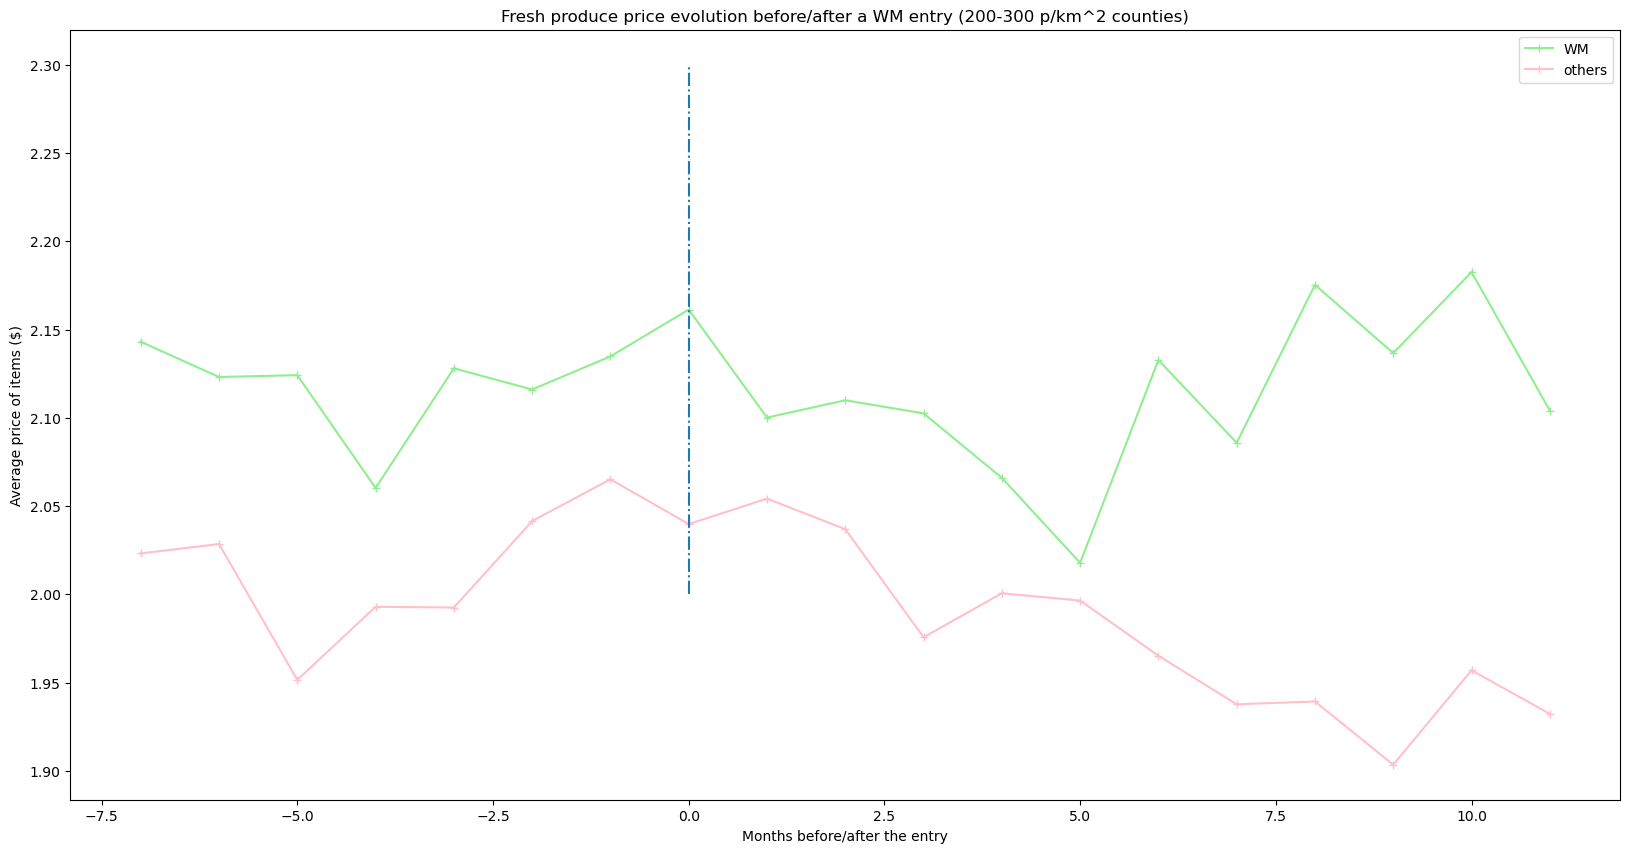

In [14]:
plt.figure(figsize=(20,10))
#plt.plot(hohowm.index, hohowm.upc_price, '-+', color='green', label='WM')
plt.plot(huhu.index, huhu.upc_price, '-+', color='lightgreen', label='WM')
#plt.plot(hoho.index, hoho.upc_price, '-+', color='red', label='others')
plt.title('Fresh produce price evolution before/after a WM entry (200-300 p/km^2 counties)')
plt.plot(hihi.index, hihi.upc_price, '-+', color='pink', label='others')
plt.legend()
plt.xlabel('Months before/after the entry')
plt.ylabel('Average price of items ($)')
plt.vlines(0, 2, 2.3, linestyles='-.');
plt.savefig("../../results_summary/descr_freshp_d=0-100.png")

Regression model :
$$ Price_{i, t} = \alpha + \beta \cdot treat_i + \delta \cdot treat_i \cdot post_{t} + \sum_{\tau=Janv15}^{Dec16}\gamma_{\tau} \cdot \mathbb{1}(t=\tau) + \sum_{s \in USStates}\gamma_{s} \cdot \mathbb{1}(state = s) + \varepsilon_{i, t}$$

In [15]:
reg0 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction)',
    data=df)
results0 = reg0.fit()

reg1 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects)',
    data=df)
results1 = reg1.fit()

reg2 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
    data=df)
results2 = reg2.fit()
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(upc_price)   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     2.275
Date:                Thu, 03 Nov 2022   Prob (F-statistic):           7.58e-98
Time:                        14:18:08   Log-Likelihood:                -6435.3
No. Observations:               32247   AIC:                         1.492e+04
Df Residuals:                   31220   BIC:                         2.353e+04
Df Model:                        1026                                         
Covariance Type:            nonrobust                                         
============================================================================================================================
                                                               coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------
Intercept                                                    0.6956      0.086      8.097      0.000       0.527       0.864
treat[T.True]                                                0.0134      0.048      0.277      0.782      -0.082       0.108
C(interaction)[T.-6]                                        -0.0350      0.077     -0.453      0.650      -0.187       0.116
C(interaction)[T.-5]                                        -0.0929      0.076     -1.225      0.220      -0.241       0.056
C(interaction)[T.-4]                                        -0.1099      0.075     -1.473      0.141      -0.256       0.036
C(interaction)[T.-3]                                        -0.0232      0.074     -0.313      0.754      -0.168       0.122
C(interaction)[T.-2]                                        -0.0733      0.074     -0.994      0.320      -0.218       0.071
C(interaction)[T.-1]                                        -0.0450      0.074     -0.610      0.542      -0.189       0.100
C(interaction)[T.0]                                         -0.0426      0.073     -0.581      0.561      -0.186       0.101
C(interaction)[T.1]                                         -0.0879      0.073     -1.199      0.231      -0.232       0.056
C(interaction)[T.2]                                         -0.0613      0.076     -0.805      0.421      -0.211       0.088
C(interaction)[T.3]                                         -0.1326      0.076     -1.742      0.081      -0.282       0.017
C(interaction)[T.4]                                         -0.1099      0.077     -1.433      0.152      -0.260       0.040
C(interaction)[T.5]                                         -0.0733      0.077     -0.949      0.343      -0.225       0.078
C(interaction)[T.6]                                          0.0016      0.078      0.021      0.983      -0.151       0.154
C(interaction)[T.7]                                         -0.0868      0.079     -1.095      0.273      -0.242       0.069
C(interaction)[T.8]                                         -0.0746      0.082     -0.915      0.360      -0.234       0.085
C(interaction)[T.9]                                         -0.0783      0.082     -0.950      0.342      -0.240       0.083
C(interaction)[T.10]                                        -0.0682      0.087     -0.787      0.431      -0.238       0.102
C(interaction)[T.11]                                        -0.0632      0.087     -0.729      0.466      -0.233       0.107
C(time_fixed_effects)[T.(1, 2016)]                           0.0222      0.064      0.347      0.729      -0.103       0.148
C(time_fixed_effects)[T.(2, 2015)]                           0.0771      0.063     

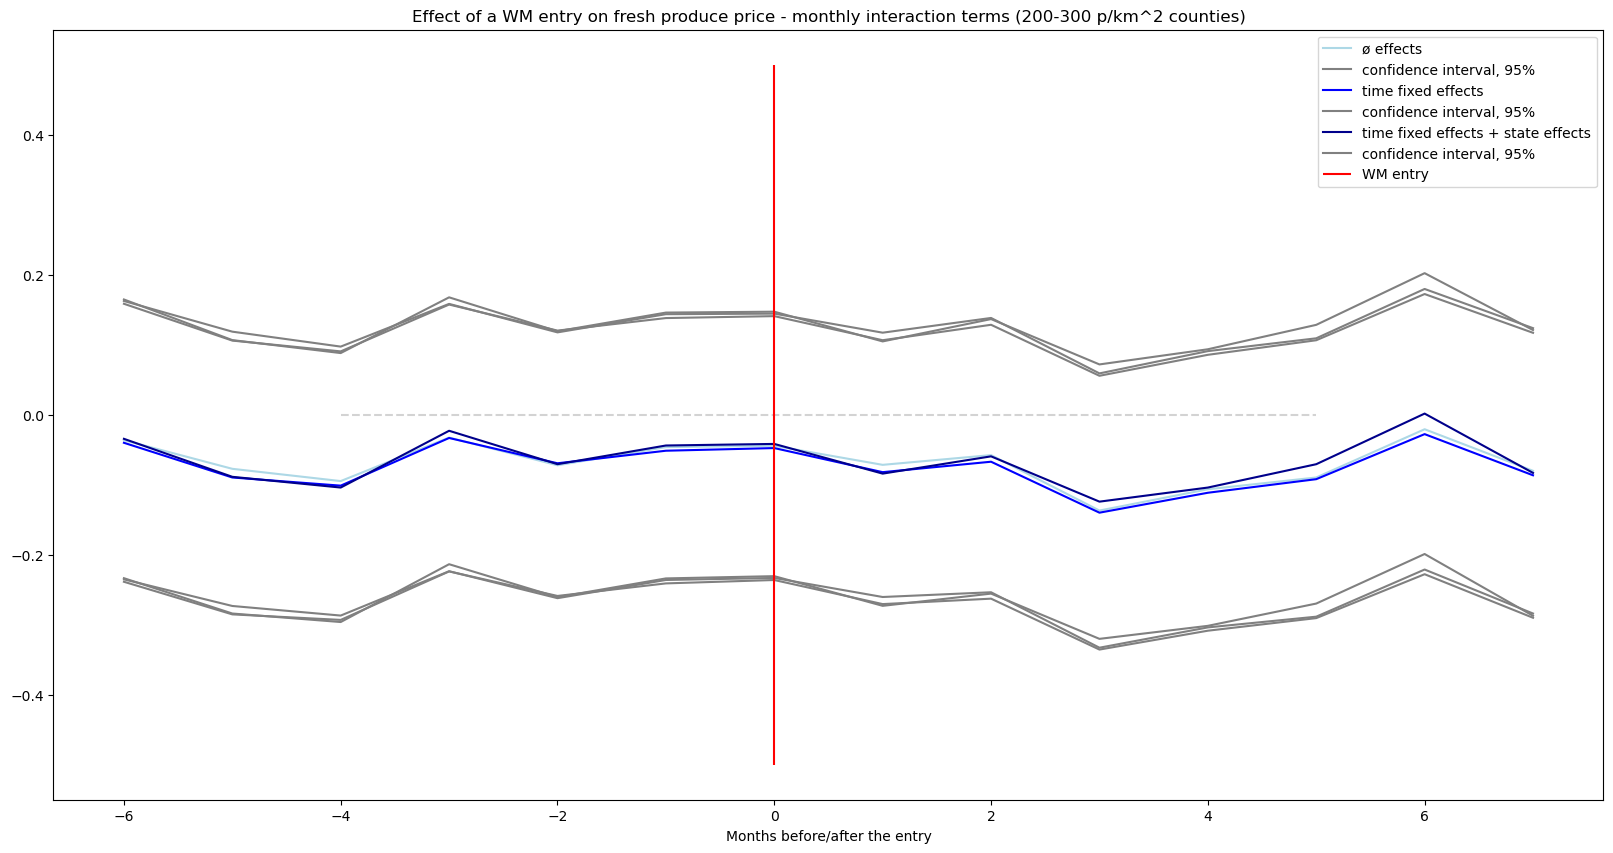

In [16]:
import scipy.stats as stats

plt.figure(figsize=(20, 10))
plt.title('Effect of a WM entry on fresh produce price - monthly interaction terms (200-300 p/km^2 counties)')
plt.xlabel('Months before/after the entry')


coefs0 = np.exp(results0.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs0) - 2)
lower_CI_5_0 = coefs0 - cv_t * results0.bse[2:16]
upper_CI_5_0 = coefs0 + cv_t * results0.bse[2:16]
plt.plot(range(-6, 8), coefs0, color='lightblue', label='ø effects')
plt.plot(range(-6, 8), lower_CI_5_0, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_0, color='grey')

coefs1 = np.exp(results1.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs1) - 2)
lower_CI_5_1 = coefs1 - cv_t * results1.bse[2:16]
upper_CI_5_1 = coefs1 + cv_t * results1.bse[2:16]
plt.plot(range(-6, 8), coefs1, color='blue', label='time fixed effects')
plt.plot(range(-6, 8), lower_CI_5_1, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_1, color='grey')

coefs2 = np.exp(results2.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs2) - 2)
lower_CI_5_2 = coefs2 - cv_t * results2.bse[2:16]
upper_CI_5_2 = coefs2 + cv_t * results2.bse[2:16]
plt.plot(range(-6, 8), coefs2, color='darkblue', label='time fixed effects + state effects' )
plt.plot(range(-6, 8), lower_CI_5_2, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_2, color='grey')


plt.plot([-4, 5], [0, 0], linestyle='--', color='lightgrey')
plt.vlines(0, -0.5, 0.5, color='red', label='WM entry')
plt.legend();
plt.savefig("../../results_summary/results_freshp_d=200-300.png")

### High density regression

In [436]:
# Final dataset for the regression :
treatment_hd = treatment[(treatment.B01001_calc_PopDensity<=4350)&(treatment.B01001_calc_PopDensity>=3915)]
control_hd = control[(control.B01001_calc_PopDensity<=4350)&(control.B01001_calc_PopDensity>=3915)]

print(f"Size of the control group: {len(control_hd.guessed_store_county_fips.unique())}.")
print(f"Size of the treatment group: {len(treatment_hd.guessed_store_county_fips.unique())}.")

df = pd.concat((control_hd, treatment_hd))[['upc_price', 'treat', 'interaction', 'time_fixed_effects',
                                            'store_state', "B01001_calc_PopDensity"]]
df = df[df.upc_price != 0]

print(treatment_hd.shape[0])
print(control_hd.shape[0])

Size of the control group: 1.
Size of the treatment group: 1.
19
24


In [191]:
wm15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
wm16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
wm15['year'] = 2015
wm16['year'] = 2016
wm = pd.concat((wm15, wm16))
wm = wm[wm.is_walmart]
wm = pd.merge(wm, density,  how='inner', left_on='guessed_store_county_fips', right_on='GEOID')


## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes still remain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]
wm = wm[~np.isin(wm.store_state, ('CA', 'GA', 'KS', 'LA', 'TX'))]

In [192]:
# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]


# We choose to focus on milk prices
product_groupwm = wm[wm.product_group_descr == 'FRESH PRODUCE']

# The control group is composed by all states where nothing (no entry nor exit) happened.
controlwm = product_groupwm[~np.isin(product_groupwm.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(controlwm.guessed_store_county_fips.unique())}.")

# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatmentwm = product_groupwm[np.isin(product_groupwm.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatmentwm = treatmentwm.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatmentwm.guessed_store_county_fips.unique())}.")

treatmentwm['treat'] = True
treatmentwm['purchase_0'] = treatmentwm.purchase_month * (treatmentwm.purchase_year == 2015) + (treatmentwm.purchase_month + 12) * (treatmentwm.purchase_year == 2016)
treatmentwm['opening_0'] = treatmentwm.Opening_date.dt.month * (treatmentwm.Opening_date.dt.year == 2015) + (treatmentwm.Opening_date.dt.month + 12) * (treatmentwm.Opening_date.dt.year == 2016)
treatmentwm['interaction'] = treatmentwm.purchase_0 - treatmentwm.opening_0
treatmentwm = treatmentwm[abs(treatmentwm.interaction) <=7]
treatmentwm['time_fixed_effects'] = list(zip(treatmentwm.purchase_month, treatmentwm.purchase_year))

treatmentwm_hd = treatmentwm[(treatmentwm.B01001_calc_PopDensity<=4350)&(treatmentwm.B01001_calc_PopDensity>=3915)]
controlwm_hd = controlwm[(controlwm.B01001_calc_PopDensity<=4350)&(controlwm.B01001_calc_PopDensity>=3915)]

print(f"Size of the control group: {len(controlwm_hd.guessed_store_county_fips.unique())}.")
print(f"Size of the treatment group: {len(treatmentwm_hd.guessed_store_county_fips.unique())}.")

dfwm = pd.concat((controlwm_hd, treatmentwm_hd))[['upc_price', 'treat', 'interaction', 'time_fixed_effects', 'store_state', "B01001_calc_PopDensity"]]
dfwm = dfwm[dfwm.upc_price != 0]

Size of the control group: 1182.
Size of the treatment group: 82.
Size of the control group: 0.
Size of the treatment group: 1.


In [195]:
huhu = treatmentwm_hd.loc[treatmentwm_hd.index.repeat(treatmentwm_hd.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()
hihi = treatment_hd.loc[treatment_hd.index.repeat(treatment_hd.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()

C:\Users\inesn\AppData\Local\Temp\ipykernel_4932\3055201021.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  huhu = treatmentwm_hd.loc[treatmentwm_hd.index.repeat(treatmentwm_hd.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()
C:\Users\inesn\AppData\Local\Temp\ipykernel_4932\3055201021.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hihi = treatment_hd.loc[treatment_hd.index.repeat(treatment_hd.nb_of_obs)].reset_index(drop=True).drop('nb_of_obs', axis=1).groupby('interaction').mean()


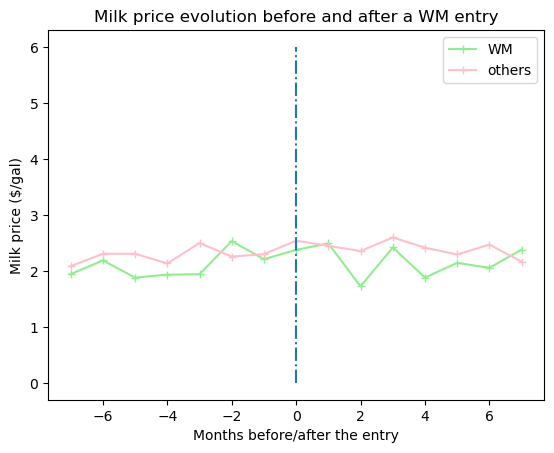

In [196]:
plt.plot(huhu.index, huhu.upc_price, '-+', color='lightgreen', label='WM')
plt.plot(hihi.index, hihi.upc_price, '-+', color='pink', label='others')
plt.title('Milk price evolution before and after a WM entry')
plt.legend()
plt.xlabel('Months before/after the entry')
plt.ylabel('Milk price ($/gal)')
#plt.ylim((0,6))
plt.vlines(0, 0, 6, linestyles='-.');

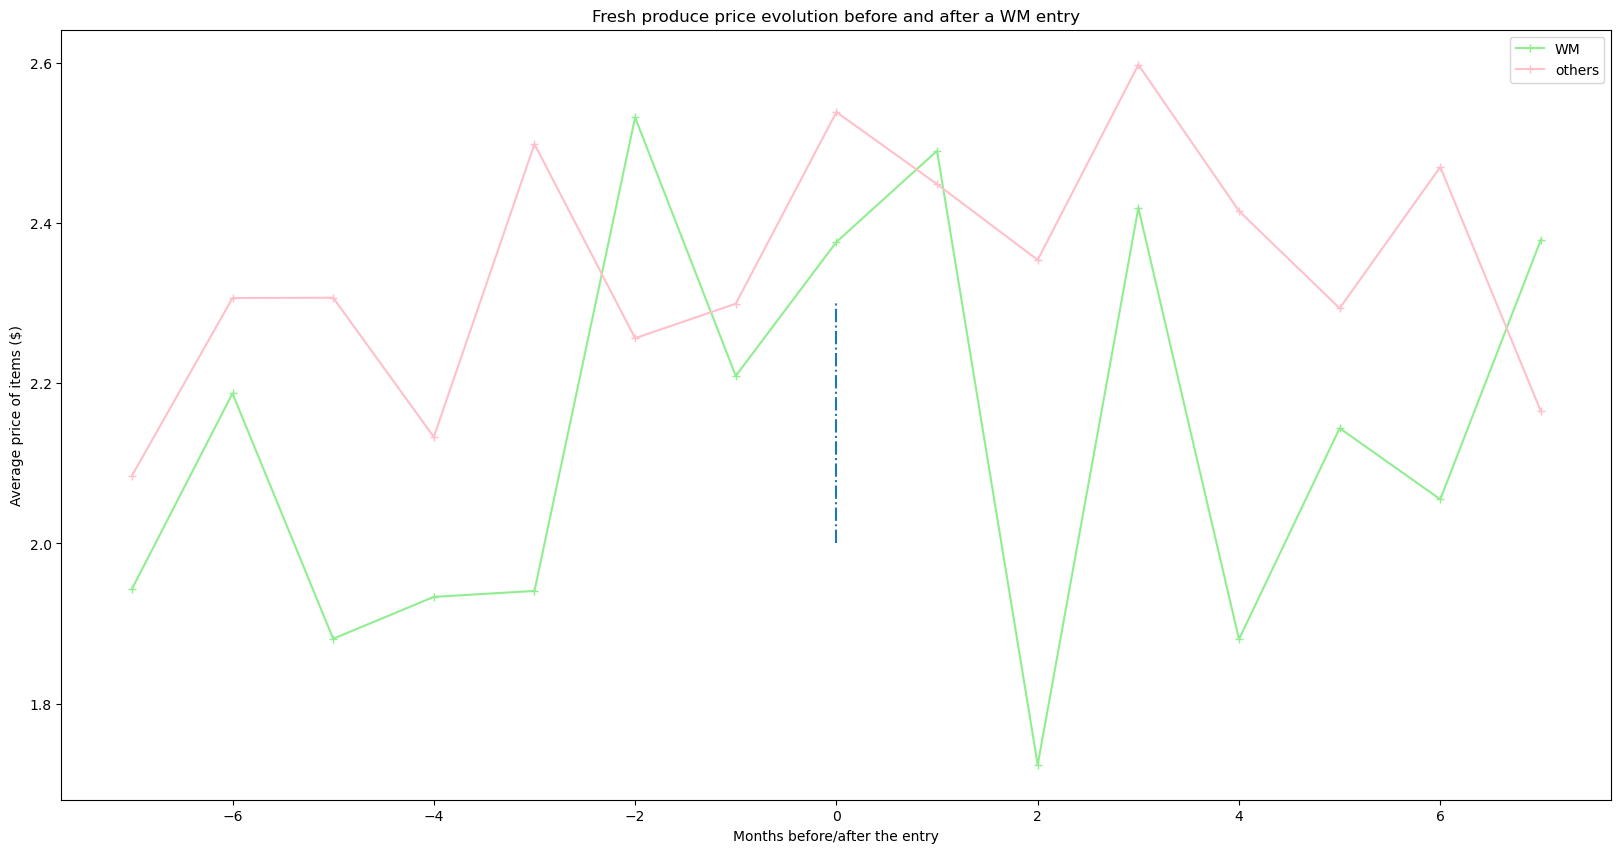

In [197]:
plt.figure(figsize=(20,10))
#plt.plot(hohowm.index, hohowm.upc_price, '-+', color='green', label='WM')
plt.plot(huhu.index, huhu.upc_price, '-+', color='lightgreen', label='WM')
#plt.plot(hoho.index, hoho.upc_price, '-+', color='red', label='others')
plt.title('Fresh produce price evolution before and after a WM entry')
plt.plot(hihi.index, hihi.upc_price, '-+', color='pink', label='others')
plt.legend()
plt.xlabel('Months before/after the entry')
plt.ylabel('Average price of items ($)')
plt.vlines(0, 2, 2.3, linestyles='-.');

Regression model :
$$ Price_{i, t} = \alpha + \beta \cdot treat_i + \delta \cdot treat_i \cdot post_{t} + \sum_{\tau=Janv15}^{Dec16}\gamma_{\tau} \cdot \mathbb{1}(t=\tau) + \sum_{s \in USStates}\gamma_{s} \cdot \mathbb{1}(state = s) + \varepsilon_{i, t}$$

In [198]:
reg0 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction)',
    data=df)
results0 = reg0.fit()

reg1 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects)',
    data=df)
results1 = reg1.fit()

reg2 = smf.ols(
    formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state) + C(time_fixed_effects)*C(store_state)',
    data=df)
results2 = reg2.fit()



C:\anaconda\envs\tr_econ\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid
C:\anaconda\envs\tr_econ\lib\site-packages\statsmodels\regression\linear_model.py:1671: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


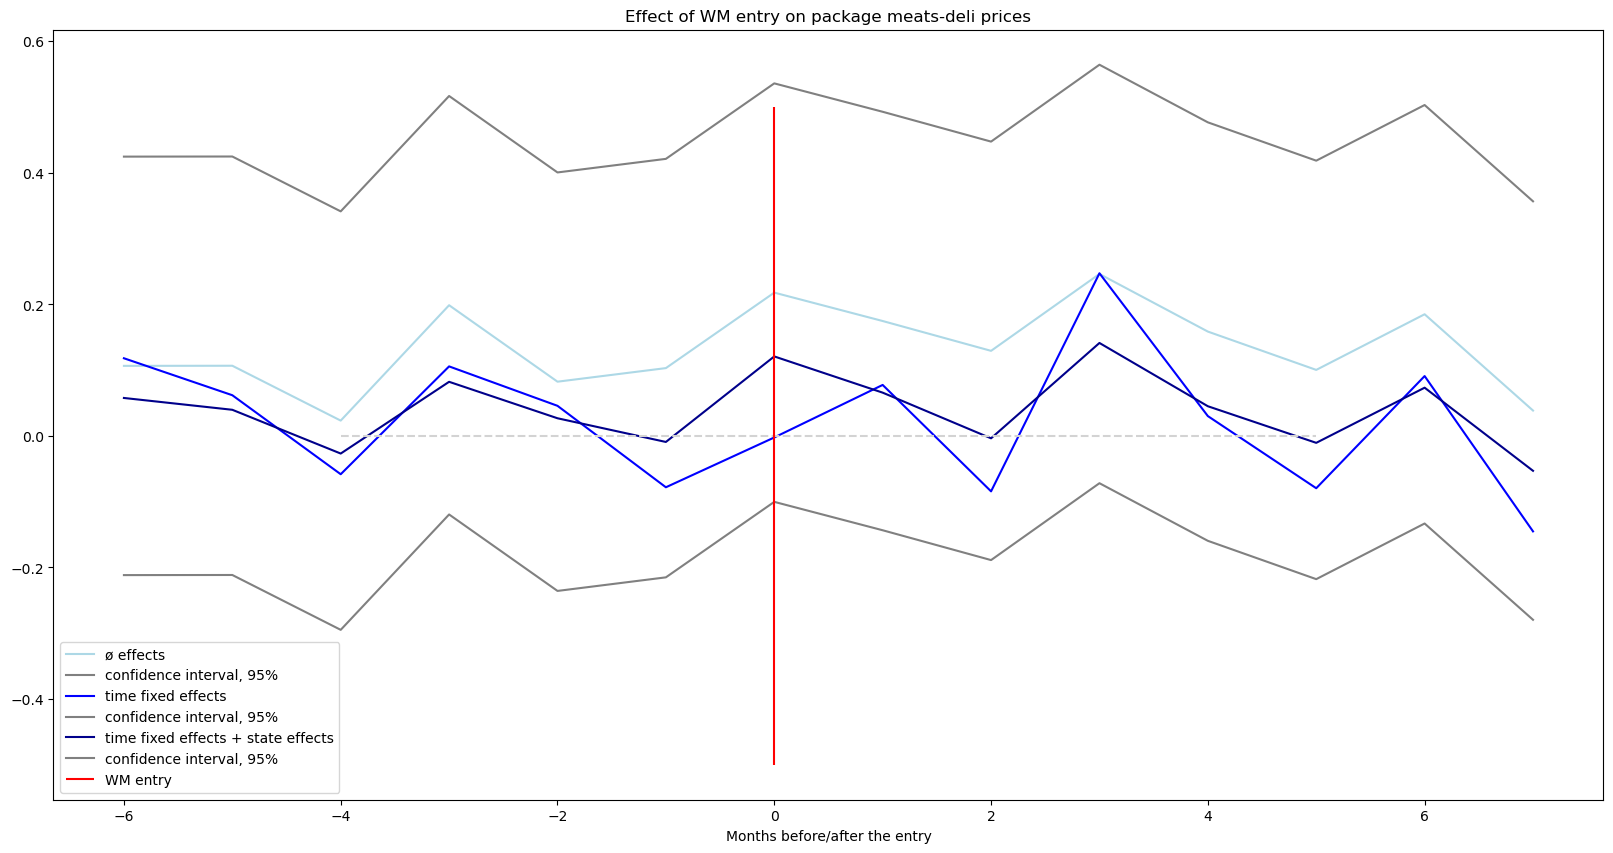

In [199]:
import scipy.stats as stats

plt.figure(figsize=(20, 10))
plt.title('Effect of WM entry on package meats-deli prices')
plt.xlabel('Months before/after the entry')


coefs0 = np.exp(results0.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs0) - 2)
lower_CI_5_0 = coefs0 - cv_t * results0.bse[2:16]
upper_CI_5_0 = coefs0 + cv_t * results0.bse[2:16]
plt.plot(range(-6, 8), coefs0, color='lightblue', label='ø effects')
plt.plot(range(-6, 8), lower_CI_5_0, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_0, color='grey')

coefs1 = np.exp(results1.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs1) - 2)
lower_CI_5_1 = coefs1 - cv_t * results1.bse[2:16]
upper_CI_5_1 = coefs1 + cv_t * results1.bse[2:16]
plt.plot(range(-6, 8), coefs1, color='blue', label='time fixed effects')
plt.plot(range(-6, 8), lower_CI_5_1, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_1, color='grey')

coefs2 = np.exp(results2.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs2) - 2)
lower_CI_5_2 = coefs2 - cv_t * results2.bse[2:16]
upper_CI_5_2 = coefs2 + cv_t * results2.bse[2:16]
plt.plot(range(-6, 8), coefs2, color='darkblue', label='time fixed effects + state effects' )
plt.plot(range(-6, 8), lower_CI_5_2, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_2, color='grey')


plt.plot([-4, 5], [0, 0], linestyle='--', color='lightgrey')
plt.vlines(0, -0.5, 0.5, color='red', label='WM entry')
plt.legend();

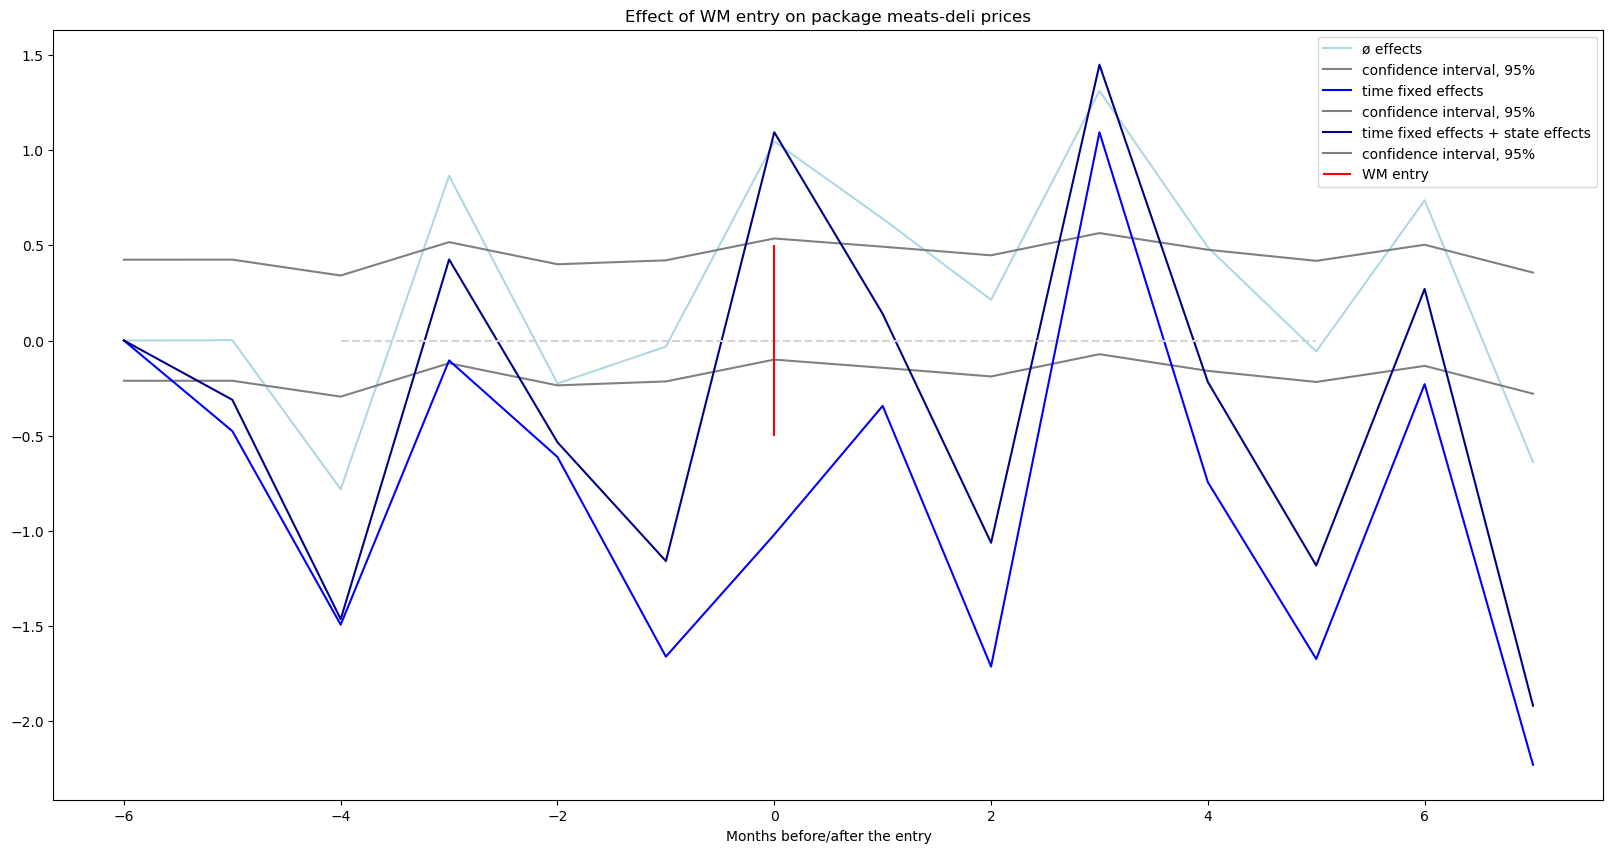

In [200]:
import scipy.stats as stats

plt.figure(figsize=(20, 10))
plt.title('Effect of WM entry on package meats-deli prices')
plt.xlabel('Months before/after the entry')


coefs0 = np.exp(results0.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs0) - 2)
lower_CI_5_0 = coefs0 - cv_t * results0.bse[2:16]
upper_CI_5_0 = coefs0 + cv_t * results0.bse[2:16]
plt.plot(range(-6, 8), (coefs0 - coefs0[0]) / coefs0[0], color='lightblue', label='ø effects')
plt.plot(range(-6, 8), lower_CI_5_0, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_0, color='grey')

coefs1 = np.exp(results1.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs1) - 2)
lower_CI_5_1 = coefs1 - cv_t * results1.bse[2:16]
upper_CI_5_1 = coefs1 + cv_t * results1.bse[2:16]
plt.plot(range(-6, 8), (coefs1 - coefs1[0]) / coefs1[0], color='blue', label='time fixed effects')
plt.plot(range(-6, 8), lower_CI_5_1, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_1, color='grey')

coefs2 = np.exp(results2.params[2:16]) - 1
cv_t = stats.t.ppf(1 - 0.005, len(df) - len(coefs2) - 2)
lower_CI_5_2 = coefs2 - cv_t * results2.bse[2:16]
upper_CI_5_2 = coefs2 + cv_t * results2.bse[2:16]
plt.plot(range(-6, 8), (coefs2 - coefs2[0]) / coefs2[0], color='darkblue', label='time fixed effects + state effects' )
plt.plot(range(-6, 8), lower_CI_5_2, color='grey', label='confidence interval, 95%')
plt.plot(range(-6, 8), upper_CI_5_2, color='grey')


plt.plot([-4, 5], [0, 0], linestyle='--', color='lightgrey')
plt.vlines(0, -0.5, 0.5, color='red', label='WM entry')
plt.legend();